# Training code for Project 3 (i.e. Tennis environment) in Udacity's Deep Reinforcement Learning nanodegree course

---

In this notebook, we will use the Unity ML-Agents environment for the 3rd project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).



## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:

import time
import os
import sys
import pickle
from collections import deque

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np
import torch

from udacity.ddpg_agent import Agent

device: cuda:0


In [2]:

print('python version:', os.path.dirname(sys.executable))
print('torch version:', torch.__version__)


python version: /home/life/.pyenv/versions/3.6.11/envs/upy36/bin
torch version: 1.7.0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# Here, I've unzipped the 'Tennis_Linux.zip' folder in the same folder as this notebook:
fn_env = './Tennis_Linux/Tennis.x86_64'
env = UnityEnvironment(file_name=fn_env)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Test run an agent in the environment

Below, an agent that makes random actions is included for testing the environment, so that we can be sure that it is working as expected.

In [6]:
def run_random_agent():
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            print('actions:', actions.shape)                   # Returns: (2, 2)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            print('next_states', next_states.shape)            # Returns: (2, 24)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
                print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

#run_random_agent()


## 4. Train the two tennis agents using DDPG (Deep Deterministic Policy Gradient)
In this section, we will train the two tennis agents using the DDPG algorithm over many episodes.

In [7]:
def ddpg(agent, n_episodes=1000, max_t=2000, train=True):
    """Trains an agent over multiple episodes using the DDPG algorithm, and returns a list of final scores for the episodes ran.
    
    Parameters
    ----------
    agent
        A DDPG agent
        
    n_episodes: int
        Maximum number of training episodes
        
    max_t: int
        Maximum number of time steps per episode. Greater this number, the agent is more likely to accumulate larger total reward.
        
    train : bool
        If True, then the agent will be trained. If False, the agent w/ preloaded weights will interact w/ the environment wo/ training.
        
    Returns
    -------
    scores: list
        A list of final scores for the episodes ran.
        
    Notes
    -----
    The `ddpg` function was taken from the Udacity nanodegree Deep Reinforcement Learning course, and adapted to the Reacher unity environment.
    """
    
    fn_scores = 'scores_train.pkl'
    if train==False:
        fn_scores = 'scores_test.pkl'
        
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        #env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        print('states[0]:', states[0])
        print('states[1]:', states[1])
        
        
        for t in range(max_t):
            actions = agent.act(states)         
      
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            
            if train == True:
                agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards
            
            
            # Each episode is 1000 steps long. However, here we are going beyond to 'max_t=2000' steps.
            # This means the agent has more chance to accumulate rewards due to longer episode.
            if np.any(dones):                                  # exit loop if episode finished
                #print('episode:', i_episode, ' t:', t)  # 
                break    
            
        
        score_max = np.max(scores)
        scores_window.append(score_max)
        all_scores.append(score_max)

        # Save data at regular interval:
        if i_episode % 100 == 0:
            with open(fn_scores, 'wb') as f:
                pickle.dump(all_scores, f)
                
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') 
          
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if train == True:
            if np.mean(scores_window) >= 0.5:
                print('Environment solved after {} episodes'.format(i_episode + 1))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') 

                break
          
    
    return all_scores


def ddpg_double(agent1, agent2, n_episodes=1000, max_t=2000, train=True):
    """Trains an agent over multiple episodes using the DDPG algorithm, and returns a list of final scores for the episodes ran.
    
    Parameters
    ----------
    agent1
        First DDPG agent
    
    agent2
        Second DDPG agent
        
    n_episodes: int
        Maximum number of training episodes
        
    max_t: int
        Maximum number of time steps per episode. Greater this number, the agent is more likely to accumulate larger total reward.
        
    train : bool
        If True, then the agent will be trained. If False, the agent w/ preloaded weights will interact w/ the environment wo/ training.
        
    Returns
    -------
    scores: list
        A list of final scores for the episodes ran.
        
    Notes
    -----
    The `ddpg` function was taken from the Udacity nanodegree Deep Reinforcement Learning course, and adapted to the Reacher unity environment.
    """
    
    fn_scores = 'scores_train.pkl'
    if train==False:
        fn_scores = 'scores_test.pkl'
        
        
    all_scores = []
    scores_window = deque(maxlen=100)
    score_max = 0
    if train == False:
        score_max = 0.25
    
    for i_episode in range(1, n_episodes+1):
        agent1.reset()
        agent2.reset()
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        #env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        #print('states[0]:', states[0])
        #print('states[1]:', states[1])
        
        
        for t in range(max_t):
            state1 = states[0]
            state2 = states[1]
            state1.shape = (-1, state_size)
            state2.shape = (-1, state_size)
            
            #action1 = agent1.act(state1)      # action1 should be (1, 2) array   
            #action2 = agent2.act(state2)         
            action1 = agent1.act(state1, score_max=score_max)      # action1 should be (1, 2) array   
            action2 = agent2.act(state2, score_max=score_max)  
            
            # Combine actions into one array:
            action1.shape = (-1, action_size)
            action2.shape = (-1, action_size)          
            actions = np.vstack([action1, action2])
            
            #print('actions:', actions)
            #print('states[0]', states[0])
            #print('states[1]', states[0])
            
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            
            if train == True:                
                
                reward1, reward2 = rewards
                
                next_state1 = next_states[0]
                next_state2 = next_states[1]
                next_state1.shape = (-1, state_size)
                next_state2.shape = (-1, state_size)
                
                done1, done2 = dones
                
                agent1.step(state1, action1, [reward1], next_state1, [done1])
                agent2.step(state2, action2, [reward2], next_state2, [done2])
            
            states = next_states
            scores += rewards
            
            
            # Each episode is 1000 steps long. However, here we are going beyond to 'max_t=2000' steps.
            # This means the agent has more chance to accumulate rewards due to longer episode.
            if np.any(dones):                                  # exit loop if episode finished
                #print('episode:', i_episode, ' t:', t)  # 
                break    
            
        
        score_max = np.max(scores)
        scores_window.append(score_max)
        all_scores.append(score_max)


        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if train == True:
            # Save data at regular interval:
            if i_episode % 100 == 0:
                with open(fn_scores, 'wb') as f:
                    pickle.dump(all_scores, f)

                torch.save(agent1.actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
                torch.save(agent1.critic_local.state_dict(), 'agent1_checkpoint_critic.pth') 
                torch.save(agent2.actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
                torch.save(agent2.critic_local.state_dict(), 'agent2_checkpoint_critic.pth') 

            if np.mean(scores_window) >= 0.5:
                print('\nEnvironment solved after {} episodes'.format(i_episode + 1))
                torch.save(agent1.actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
                torch.save(agent1.critic_local.state_dict(), 'agent1_checkpoint_critic.pth') 
                torch.save(agent2.actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
                torch.save(agent2.critic_local.state_dict(), 'agent2_checkpoint_critic.pth') 

                break
          
    
    return all_scores

In [8]:
# Train an agent:
seed = 0
agent1 = Agent(state_size, action_size, steps_random=2000, random_seed=seed)
agent2 = Agent(state_size, action_size, steps_random=2000, random_seed=seed)


ts_i = time.time()

#scores = ddpg_double(agent1, agent2, n_episodes=10)
#scores = ddpg_double(agent1, agent2, n_episodes=1000)
#scores = ddpg_double(agent1, agent2, n_episodes=2000)
#scores = ddpg_double(agent1, agent2, n_episodes=5000)
scores = ddpg_double(agent1, agent2, n_episodes=50000)

#scores = ddpg(agent, n_episodes=10)
#scores = ddpg(agent, n_episodes=300)
#scores = ddpg(agent, n_episodes=1)    # For troubleshooting.
#scores = ddpg(agent, n_episodes=5000)

ts_j = time.time()
ts_diff = ts_j - ts_i
print('Training took:', ts_diff/60., ' minutes')

# Save scores:
with open('scores_train.pkl', 'wb') as f:
    pickle.dump(scores, f)

Episode 100	Average Score: 0.02
Episode 105	Average Score: 0.02steps_random=2000 reached
steps_random=2000 reached
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.01
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.00
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.00
Episode 1300	Average Score: 0.00
Episode 1400	Average Score: 0.01
Episode 1500	Average Score: 0.01
Episode 1600	Average Score: 0.02
Episode 1700	Average Score: 0.06
Episode 1800	Average Score: 0.05
Episode 1900	Average Score: 0.06
Episode 2000	Average Score: 0.07
Episode 2100	Average Score: 0.06
Episode 2200	Average Score: 0.09
Episode 2300	Average Score: 0.16
Episode 2400	Average Score: 0.11
Episode 2500	Average Score: 0.10
Episode 2600	Average Score: 0.12
Episode 2700	Average Score: 0.11
Episode 2800	Average Score: 0.11
Ep

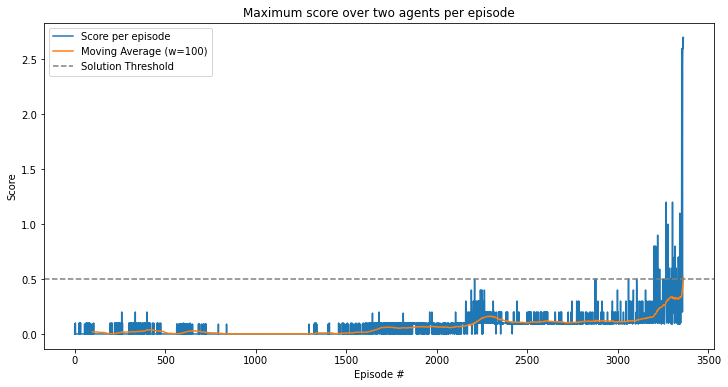

In [9]:

# Moving average with window size of 100:
w = 100
scores_ma = np.convolve(scores, np.ones(w), 'valid') / w
idx = range(w-1, len(scores))

# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

plt.plot(scores, label='Score per episode')
plt.plot(idx, scores_ma, label='Moving Average (w=100)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Maximum score over two agents per episode')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Solution Threshold')
plt.legend()


## 5. Confirm that the saved weights contain the trained agent that performs better

In this section, we will load learned neural network weights from files `checkpoint_actor.pth` and `checkpoint_critic.pth` into an agent, and re-run agent without training, and evaluate its performance.

Note that an average score of 0.5+ for 100 consecutive episodes is considered "solving" the environment.

In [10]:
# Load the model weights from the previous Training step into a new agent:

# Test agents:

test_agent1 = Agent(state_size, action_size, random_seed=0)
test_agent2 = Agent(state_size, action_size, random_seed=0)

test_agent1.actor_local.load_state_dict(torch.load('agent1_checkpoint_actor.pth', map_location=torch.device('cpu')))
test_agent1.critic_local.load_state_dict(torch.load('agent1_checkpoint_critic.pth', map_location=torch.device('cpu')))

test_agent2.actor_local.load_state_dict(torch.load('agent2_checkpoint_actor.pth', map_location=torch.device('cpu')))
test_agent2.critic_local.load_state_dict(torch.load('agent2_checkpoint_critic.pth', map_location=torch.device('cpu')))

test_agent1.actor_local.eval()
test_agent1.critic_local.eval()

test_agent2.actor_local.eval()
test_agent2.critic_local.eval()



Critic(
  (model_1): Sequential(
    (0): Linear(in_features=24, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model_2): Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [11]:
# Run the new agents for n_episodes:
scores_test = ddpg_double(test_agent1, test_agent2, n_episodes=100, train=False)

with open('scores_test.pkl', 'wb') as f:
    pickle.dump(scores_test, f)

Episode 100	Average Score: 2.63


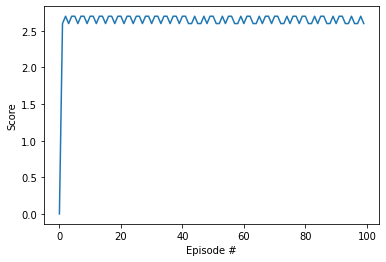

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

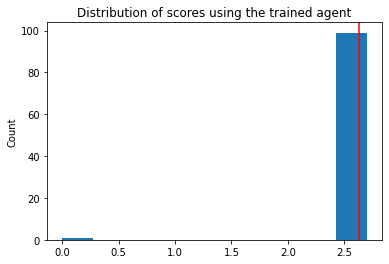

In [13]:
## Distribution of scores
score_mean = np.mean(scores_test)

plt.hist(scores_test, bins=10)
plt.ylabel('Count')
plt.title('Distribution of scores using the trained agent')
plt.axvline(x=score_mean, color='red')

In [14]:
print('Mean Score:', score_mean)

Mean Score: 2.629000039175153


In [15]:
env.close()